#### Đọc dữ liệu

In [1]:
import pandas as pd

dt1 = pd.read_csv('./Dataset-ThayDau/FFmpeg_full.csv')
dt2 = pd.read_csv('./Dataset-ThayDau/LibPNG_full.csv')
dt3 = pd.read_csv('./Dataset-ThayDau/LibTIFF_full.csv')
dt4 = pd.read_csv('./Dataset-ThayDau/VLC_full.csv')

In [2]:
dt1.shape

(5765, 2)

In [3]:
dt2.shape

(621, 2)

In [4]:
dt3.shape

(827, 2)

In [5]:
dt4.shape

(6362, 2)

In [6]:
dt5 = pd.read_csv('./Dataset-ChiThuy-Sy/juliet_dataset.csv')
dt5.shape

(200050, 2)

In [7]:
# data = pd.concat([dt1, dt2, dt3, dt4])
data = dt5
data.shape

(200050, 2)

#### Lọc các giá trị Null

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200050 entries, 0 to 200049
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   code    200050 non-null  object
 1   label   200050 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.1+ MB


In [9]:
# Loại bỏ các dòng có giá trị null trong cột 'code'
data.dropna(subset=['code'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200050 entries, 0 to 200049
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   code    200050 non-null  object
 1   label   200050 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.1+ MB


#### Lọc các trường hợp bị trùng nhau

In [10]:
data.duplicated().sum()

28900

In [11]:
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

In [12]:
data.shape

(171150, 2)

In [13]:
dt0 = data
dt0.shape

(171150, 2)

In [14]:
data = dt0

#### Phân phối của dataset

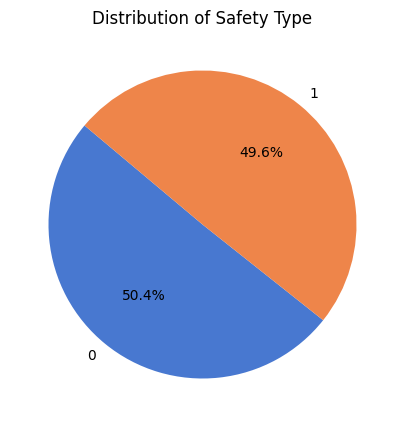

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
colors = sns.color_palette('muted')
val = data['label'].value_counts().values
ind = data['label'].value_counts().index
plt.figure(figsize=(5,5))
plt.pie(val, labels=ind, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title(f'Distribution of Safety Type')
plt.show()

#### Kế thừa các tham số từ mô hình CodeBERT

In [1]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
from transformers import RobertaTokenizer, RobertaModel

tokenizer = RobertaTokenizer.from_pretrained("./codebert")
model = RobertaModel.from_pretrained("./codebert")

OSError: Incorrect path_or_model_id: './codebert'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

#### Thêm các lớp phân loại

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CodeVulnerabilityClassifier(nn.Module):
    def __init__(self, codebert_model):
        super(CodeVulnerabilityClassifier, self).__init__()
        self.codebert = codebert_model
        # for param in self.codebert.parameters():
        #     param.requires_grad = False

        self.fc1 = nn.Linear(768, 512)  
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, input_ids, attention_mask):
        outputs = self.codebert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]  
        out1 = F.relu(self.fc1(pooled_output)) 
        out2 = F.relu(self.fc2(out1))  
        logits = self.fc3(out2)  
        return logits


#### Xử lý dữ liệu 

In [18]:
# Chia tập dữ liệu thành tập train và tập test (giả sử data là dataframe chứa 'code' và 'safety' fields)
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Tiền xử lý dữ liệu và chuyển đổi thành dạng tensor sử dụng tokenizer
train_texts = train_data['code'].tolist()
for i in range(len(train_texts)):
    if not isinstance(train_texts[i], str):
        print(train_texts[i])
        train_texts[i] = str(train_texts[i])
train_labels = train_data['label'].tolist()

test_texts = test_data['code'].tolist()
for i in range(len(test_texts)):
    if not isinstance(test_texts[i], str):
        print(train_texts[i])
        test_texts[i] = str(test_texts[i])
test_labels = test_data['label'].tolist()


#### Encoding dữ liệu

In [19]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256, return_tensors='pt')
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=256, return_tensors='pt')

train_dataset = torch.utils.data.TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(train_labels))
test_dataset = torch.utils.data.TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(test_labels))


#### Chọn bộ tối ưu, hàm mất mát, batch_size

In [20]:
batch_size = 128
learning_rate = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
classifier = CodeVulnerabilityClassifier(model)
classifier.to(device)

optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#### Huấn luyện mô hình

In [21]:
from tqdm.notebook import tqdm
for epoch in tqdm(range(1), total=1):
    for input_ids, attention_mask, labels in train_loader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        optimizer.zero_grad()
        logits = classifier(input_ids, attention_mask)
        loss = loss_fn(logits, labels)
        # loss = loss_fn(threads, labels)
        print(loss)
        loss.backward()
        optimizer.step()


  0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.7000, grad_fn=<NllLossBackward0>)
tensor(0.6938, grad_fn=<NllLossBackward0>)
tensor(0.6988, grad_fn=<NllLossBackward0>)
tensor(0.6917, grad_fn=<NllLossBackward0>)
tensor(0.6911, grad_fn=<NllLossBackward0>)
tensor(0.6877, grad_fn=<NllLossBackward0>)
tensor(0.6835, grad_fn=<NllLossBackward0>)
tensor(0.6731, grad_fn=<NllLossBackward0>)
tensor(0.6572, grad_fn=<NllLossBackward0>)
tensor(0.6496, grad_fn=<NllLossBackward0>)
tensor(0.6217, grad_fn=<NllLossBackward0>)
tensor(0.6086, grad_fn=<NllLossBackward0>)
tensor(0.5769, grad_fn=<NllLossBackward0>)
tensor(0.5444, grad_fn=<NllLossBackward0>)
tensor(0.5088, grad_fn=<NllLossBackward0>)
tensor(0.5255, grad_fn=<NllLossBackward0>)
tensor(0.5228, grad_fn=<NllLossBackward0>)
tensor(0.4182, grad_fn=<NllLossBackward0>)
tensor(0.5280, grad_fn=<NllLossBackward0>)
tensor(0.4938, grad_fn=<NllLossBackward0>)
tensor(0.4592, grad_fn=<NllLossBackward0>)
tensor(0.4972, grad_fn=<NllLossBackward0>)
tensor(0.4551, grad_fn=<NllLossBackward0>)
tensor(0.43

#### Đánh giá mô hình

In [26]:
# Đánh giá mô hình trên tập test
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
threshold = 0.4

while(threshold<=0.6):
    correct = 0
    total = 0

    with torch.no_grad():
        for input_ids, attention_mask, labels in test_loader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            
            logits = classifier(input_ids, attention_mask)

            probs = torch.nn.functional.softmax(logits, dim=1)  # Chuyển đổi logits thành xác suất
            predictions = (probs[:, 1] > threshold).long()  # Sử dụng ngưỡng quyết định
            total += labels.size(0)
            correct += (predictions == labels).sum().item()
            
    accuracy = correct / total
    print(f'Threshold: {threshold} Accuracy: {accuracy}')
    threshold += 0.1

Threshold: 0.4 Accuracy: 0.8927548933683903
Threshold: 0.5 Accuracy: 0.8972246567338592
Threshold: 0.6 Accuracy: 0.8949751679813029


#### Lưu mô hình

In [23]:
# Trước khi lưu hãy đặt tên lại cho folder đích theo cấu hình của model 
# Đặt tên theo quy tắc: model_số layer_bộ tối ưu_learning rate_accuracy

model.save_pretrained('./model_test')
tokenizer.save_pretrained('./model_test')

('./model_test\\tokenizer_config.json',
 './model_test\\special_tokens_map.json',
 './model_test\\vocab.json',
 './model_test\\merges.txt',
 './model_test\\added_tokens.json')

In [27]:
torch.save({'model_state_dict': classifier.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss':loss.item(),
            },'h.pth')